### Reading in data from pkl files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
X_all = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_train_all_x.pkl').iloc[:,0:300]
y_all = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_train_all_y.pkl')

In [5]:
X_all, y_all

(           0         1         2    ...       297       298       299
 0     0.041617 -0.007669 -0.099326  ... -0.165230 -0.073722  0.019793
 1     0.013496  0.011007 -0.150378  ... -0.204297 -0.124606  0.051673
 2    -0.036476 -0.000075 -0.114731  ... -0.297416 -0.190954  0.075475
 3    -0.024779 -0.024006 -0.135217  ... -0.324523 -0.218261  0.068250
 4     0.010332  0.016948 -0.133872  ... -0.222715 -0.169144  0.061331
 ...        ...       ...       ...  ...       ...       ...       ...
 7495  0.066026  0.093786 -0.172993  ... -0.188306 -0.189566  0.073333
 7496 -0.044580  0.071476 -0.205188  ... -0.248129 -0.291212  0.107295
 7497  0.059447  0.106973 -0.197400  ... -0.184039 -0.205954  0.088878
 7498 -0.003087  0.071542 -0.176654  ... -0.209037 -0.226854  0.076096
 7499  0.069718  0.127816 -0.186054  ... -0.156750 -0.230374  0.087679
 
 [7500 rows x 300 columns],        label
 657        1
 14830      1
 6327       1
 25609      1
 32369      1
 ...      ...
 89774      3
 100676

In [6]:
X_labeled = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_train_x_split1.pkl')
y_labeled = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_train_y_split1.pkl')
X_labeled, y_labeled

(           0         1         2    ...       297       298       299
 693   0.049199 -0.011482 -0.110103  ... -0.217203 -0.142227  0.053564
 1546  0.010676  0.031176 -0.138275  ... -0.221373 -0.180964  0.073210
 1434 -0.035490 -0.046898 -0.213250  ... -0.257092 -0.185040  0.046856
 2474  0.022921  0.027537 -0.094850  ... -0.225837 -0.172324  0.060848
 11    0.016461  0.027128 -0.108252  ... -0.191487 -0.151625  0.049681
 ...        ...       ...       ...  ...       ...       ...       ...
 7214 -0.010215  0.034705 -0.143907  ... -0.181218 -0.165945  0.062886
 7179  0.068308  0.121399 -0.173262  ... -0.185791 -0.218021  0.095291
 5613 -0.048953  0.100923 -0.255677  ... -0.263243 -0.335946  0.118258
 7138  0.022816  0.055197 -0.140045  ... -0.209869 -0.206295  0.074287
 5422  0.054857  0.072091 -0.238507  ... -0.177334 -0.185686  0.057452
 
 [375 rows x 300 columns],       label
 693       1
 1546      1
 1434      1
 2474      1
 11        1
 ...     ...
 7214      3
 7179      3
 56

# VAT Torch Implementation

In [7]:
# A torch implementation of VAT.
# import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
    
def normalize(d):
    d /= (torch.sqrt(torch.sum(d**2, axis=1)).view(-1,1)+1e-16)
    return d

def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-16
    return d

def _kl_div(p,q):
    '''
    D_KL(p||q) = Sum(p log p - p log q)
    '''
    logp = torch.nn.functional.log_softmax(p,dim=1)
    logq = torch.nn.functional.log_softmax(q,dim=1)
    p = torch.exp(logp)
    return (p*(logp-logq)).sum(dim=1,keepdim=True).mean()

class VATLoss(nn.Module):
    def __init__(self, xi = .0001, eps = 0.1, ip = 2, device='cpu'):
        """
        :xi: hyperparameter: small float for finite difference threshold 
        :eps: hyperparameter: value for how much to deviate from original X.
        :ip: value of power iteration for approximation of r_vadv.
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip
        
    def forward(self, model, x):
        with torch.no_grad():
            pred = model(x)
            
        # random unit tensor for perturbation
        d = torch.randn(x.shape).to(device)
        d = _l2_normalize(d)
        
        #calculating adversarial direction
        for _ in range(self.ip):
            d.requires_grad_()
            pred_hat = model(x + self.xi * d)
            adv_distance = _kl_div(pred_hat, pred)
            if torch.isnan(adv_distance):
                print(pred_hat, pred)
                print(x)
                break
            adv_distance.backward()
            d = _l2_normalize(d.grad.data)
            model.zero_grad()
        
        r_adv = d*self.eps
        pred_hat = model(x+r_adv)
        lds = _kl_div(pred_hat, pred)
        return lds

# Simple NN Torch Implementation

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(300,100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100, 4)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [9]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)
device

device(type='cuda', index=0)

In [10]:
X_all = X_all.replace(np.nan, 0) 
X_labeled = X_labeled.replace(np.nan, 0) 
y_all.transpose().values.astype('int')
# y_labeled.transpose()

array([[1, 1, 1, ..., 3, 3, 3]])

In [11]:
from sklearn.metrics import accuracy_score

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, eps=1e-3)

X_all_tensor = torch.from_numpy(X_all.values).float().to(device)
y_all_tensor = torch.from_numpy(y_all.values.astype('int')).long().to(device)
X_labeled_tensor = torch.from_numpy(X_labeled.values).float().to(device)
y_labeled_tensor = torch.from_numpy(y_labeled.transpose().values[0]).to(device)
dataset = torch.utils.data.TensorDataset(X_all_tensor, y_all_tensor)


i_total_step = 0
gamma = 4e1
num_epochs = 5
for i in range(num_epochs): # epoch
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=True) #batch size 
    print(f"Epoch: {i}")
    for u, _ in data_loader:
        i_total_step += 1
        vat_loss = VATLoss( xi = .0001, eps = .1, ip = 1, device=device)
        cross_entropy = nn.CrossEntropyLoss()

        lds = vat_loss(model, torch.tensor(u).float().to(device))
        output = model(X_labeled_tensor)
        classification_loss = cross_entropy(output, y_labeled_tensor)
        loss = classification_loss + gamma * lds
        # loss = classification_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = accuracy_score(y_labeled,np.argmax(output.data.cpu().numpy(), axis=1))
        ce_losses = classification_loss.item()
        vat_losses = gamma*lds.item()
        # if i_total_step % 50000 == 0:
    print("CrossEntropyLoss %f:" % (ce_losses))
    print("VATLoss %f:" % (vat_losses))
    print("Accuracy %f:" % (accuracy)) 
    print("LDS %f:" % (lds)) 
    print("---------------------------------")

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


CrossEntropyLoss 0.803437:
VATLoss 0.034953:
Accuracy 0.858667:
LDS 0.000874:
---------------------------------
Epoch: 1
CrossEntropyLoss 0.667773:
VATLoss 0.296720:
Accuracy 0.882667:
LDS 0.007418:
---------------------------------
Epoch: 2
CrossEntropyLoss 0.593027:
VATLoss 0.229921:
Accuracy 0.888000:
LDS 0.005748:
---------------------------------
Epoch: 3
CrossEntropyLoss 0.534389:
VATLoss 0.139459:
Accuracy 0.890667:
LDS 0.003486:
---------------------------------
Epoch: 4
CrossEntropyLoss 0.502078:
VATLoss 0.035829:
Accuracy 0.896000:
LDS 0.000896:
---------------------------------


In [12]:
from sklearn.metrics import accuracy_score

out = model(X_all_tensor)
y_pred = np.argmax(out.detach().cpu().numpy(), axis=1)
y_true = y_all.transpose().values[0].astype('int')
print("{0} vat acc".format(accuracy_score(y_true, y_pred)))

0.8828 vat acc


In [13]:
print(y_pred)
print(y_true)

[1 1 1 ... 3 3 3]
[1 1 1 ... 3 3 3]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Classification Report:
              precision    recall  f1-score   support

           1     0.8083    0.8536    0.8304      2500
           2     0.9876    0.8252    0.8991      2500
           3     0.8748    0.9696    0.9197      2500

    accuracy                         0.8828      7500
   macro avg     0.8902    0.8828    0.8831      7500
weighted avg     0.8902    0.8828    0.8831      7500



[Text(0, 0.5, '1'), Text(0, 1.5, '2'), Text(0, 2.5, '3')]

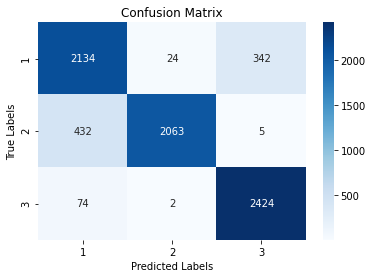

In [15]:
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=np.unique(y_true), digits=4))

cm = confusion_matrix(y_true, y_pred, np.unique(y_true))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(np.unique(y_true))
ax.yaxis.set_ticklabels(np.unique(y_pred))

In [16]:
from sklearn.metrics import accuracy_score

test_X_all = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_test_wv.pkl').iloc[:,0:300]
test_y_all = pd.read_pickle('/content/drive/My Drive/AML_Project/binaries/dbpedia_test_wv.pkl')['label']
test_X_all_tensor = torch.from_numpy(test_X_all.values).float().to(device)
test_y_all_tensor = torch.from_numpy(test_y_all.values.astype('int')).long().to(device)

X_all = X_all.replace(np.nan, 0) 
X_labeled = X_labeled.replace(np.nan, 0) 
y_all.transpose().values.astype('int')
# y_labeled.transpose()

out = model(test_X_all_tensor)
y_pred = np.argmax(out.detach().cpu().numpy(), axis=1)
y_true = np.hstack(test_y_all)#.transpose()#.values[0]#.astype('int')

In [17]:
print(y_pred)
print(y_true)

[1 1 1 ... 3 3 3]
[1 1 1 ... 3 3 3]


In [18]:
print("{0} vat acc".format(accuracy_score(y_true, y_pred)))

0.8808888888888889 vat acc


Classification Report:
              precision    recall  f1-score   support

           1     0.8092    0.8427    0.8256       750
           2     0.9872    0.8240    0.8983       750
           3     0.8683    0.9760    0.9190       750

    accuracy                         0.8809      2250
   macro avg     0.8883    0.8809    0.8810      2250
weighted avg     0.8883    0.8809    0.8810      2250



[Text(0, 0.5, '1'), Text(0, 1.5, '2'), Text(0, 2.5, '3')]

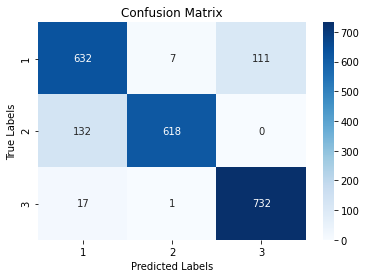

In [19]:
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=np.unique(y_true), digits=4))

cm = confusion_matrix(y_true, y_pred, np.unique(y_true))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(np.unique(y_true))
ax.yaxis.set_ticklabels(np.unique(y_pred))